In [1]:
import os, sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
import numpy as np
import pandas as pd
from ppi_py.datasets import load_dataset
from ppi_py import ppi_ols_covshift_ci, classical_ols_covshift_ci, classical_ols_ci
from statsmodels.regression.linear_model import OLS
from scipy.optimize import brentq
from tqdm import tqdm
from utils import *

# Import the census income data set

In [2]:
dataset_folder = "./data/"
data = load_dataset(dataset_folder, "census_income")
Y_total = data["Y"]
Yhat_total = data["Yhat"]
X_total = data["X"][:,0:1] # Age
Z_total = data["X"][:,1:2]-1 # Sex

# Problem setup

In [3]:
alpha = 0.05
coordinate = 0
weights = np.array([0.8, 0.2]) # Women, men in the new population
n_total = Y_total.shape[0]  # Total number of labeled examples
n_inD = 10000
ns = np.linspace(100, 2000, 10).astype(
    int
)  # Test for different numbers of labeled ballots
num_trials = 100

In [4]:
# Generate indexes for inD and ooD datasets.
randperm = np.random.permutation(n_total)
inD_idxs, temp_idxs = randperm[:n_inD], randperm[n_inD:]
probability_vector = np.array([weights[0] if z == 0 else weights[1] for z in Z_total[temp_idxs]])
probability_vector /= probability_vector.sum()
size = int((n_total - n_inD) * min(weights[0]/weights[1], weights[1]/weights[0]))
shifted_idxs = np.random.choice(temp_idxs, size=size, replace=False, p=probability_vector)

In [5]:
# Generate inD and ooD datasets
X_inD, X_ooD = X_total[inD_idxs], X_total[shifted_idxs]
Y_inD, Y_ooD = Y_total[inD_idxs], Y_total[shifted_idxs]
Yhat_inD, Yhat_ooD = Yhat_total[inD_idxs], Yhat_total[shifted_idxs]
Z_inD, Z_ooD = Z_total[inD_idxs], Z_total[shifted_idxs]

In [6]:
# Compute ground truth
true_theta = OLS(Y_ooD, exog=X_ooD).fit().params[coordinate]

# Construct intervals

In [7]:
# Run prediction-powered inference and classical inference for many values of n
results = []
for i in tqdm(range(ns.shape[0])):
    for j in range(num_trials):
        # Prediction-Powered Inference
        n = ns[i]
        rand_idx = np.random.permutation(n_inD)
        _X = X_inD[rand_idx[:n]]
        _Y = Y_inD[rand_idx[:n]]
        _Z = Z_inD[rand_idx[:n]]
        _Yhat = Yhat_inD[rand_idx[:n]]
        probability_vector = np.array([weights[0] if z == 0 else weights[1] for z in _Z])
        probability_vector /= probability_vector.sum()

        ppi_ci = ppi_ols_covshift_ci(
            _X, _Y, _Yhat, X_ooD, Yhat_ooD, probability_vector, alpha=alpha
        )

        # Classical interval
        classical_ci = classical_ols_covshift_ci(_X, _Y, probability_vector, alpha=alpha)

        # Append results
        results += [
            pd.DataFrame(
                [
                    {
                        "method": "PPI",
                        "n": n,
                        "lower": ppi_ci[0][coordinate],
                        "upper": ppi_ci[1][coordinate],
                        "trial": j,
                    }
                ]
            )
        ]
        results += [
            pd.DataFrame(
                [
                    {
                        "method": "Classical",
                        "n": n,
                        "lower": classical_ci[0][coordinate],
                        "upper": classical_ci[1][coordinate],
                        "trial": j,
                    }
                ]
            )
        ]

# Imputed CI
imputed_ci = classical_ols_ci(X_ooD, Yhat_ooD, alpha=alpha)
results += [
    pd.DataFrame(
        [
            {
                "method": "Imputation",
                "n": np.nan,
                "lower": imputed_ci[0][coordinate],
                "upper": imputed_ci[1][coordinate],
                "trial": 0,
            }
        ]
    )
]

df = pd.concat(results, axis=0, ignore_index=True)
df["width"] = df["upper"] - df["lower"]

100%|███████████████████████████████████████████| 10/10 [00:06<00:00,  1.64it/s]


# Plot results

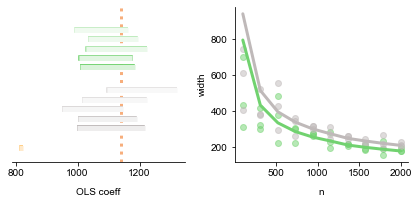

In [8]:
make_plots(
    df,
    "./plots/census_income_covshift.pdf",
    intervals_xlabel="OLS coeff",
    true_theta=true_theta,
    empty_panel=False
)

In [9]:
# Find n such that we reject H0: OLS coeff < 800 with probability 80% using a test at level alpha
num_experiments = 100
list_rand_idx = [
    np.random.permutation(n_inD) for i in range(num_experiments)
]


def _to_invert_ppi(n):
    n = int(n)
    nulls_rejected = 0
    # Data setup
    for i in range(num_experiments):
        rand_idx = list_rand_idx[i]
        _X = X_inD[rand_idx[:n]]
        _Y = Y_inD[rand_idx[:n]]
        _Z = Z_inD[rand_idx[:n]]
        _Yhat = Yhat_inD[rand_idx[:n]]
        probability_vector = np.array([weights[0] if z == 0 else weights[1] for z in _Z])
        probability_vector /= probability_vector.sum()

        ppi_ci = ppi_ols_covshift_ci(
            _X, _Y, _Yhat, X_ooD, Yhat_ooD, probability_vector, alpha=alpha
        )

        if ppi_ci[0][coordinate] > 800:
            nulls_rejected += 1
    return nulls_rejected / num_experiments - 0.8


def _to_invert_classical(n):
    n = int(n)
    nulls_rejected = 0
    # Data setup
    for i in range(num_experiments):
        rand_idx = list_rand_idx[i]
        _X = X_inD[rand_idx[:n]]
        _Y = Y_inD[rand_idx[:n]]
        _Z = Z_inD[rand_idx[:n]]
        probability_vector = np.array([weights[0] if z == 0 else weights[1] for z in _Z])
        probability_vector /= probability_vector.sum()

        classical_ci = classical_ols_covshift_ci(
            _X, _Y, probability_vector, alpha=alpha
        )

        if classical_ci[0][coordinate] > 800:
            nulls_rejected += 1
    return nulls_rejected / num_experiments - 0.8

In [10]:
n_ppi = int(brentq(_to_invert_ppi, 100, 2000, xtol=1))
n_classical = int(brentq(_to_invert_classical, 100, 10000, xtol=1))
print(
    f"The PPI test requires n={n_ppi} labeled data points to reject the null."
)
print(
    f"The classical test requires n={n_classical} labeled data points to reject the null."
)

The PPI test requires n=216 labeled data points to reject the null.
The classical test requires n=323 labeled data points to reject the null.
